In [5]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display

import duckdb
import pandas as pd
from pathlib import Path
import logging
from Bio import SeqIO
from datetime import datetime
import time

from typing import List, Optional, Union, Dict, Set

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build initial database

We're using our `database.builder` module to build the database.

TODO: Add logic to only insert sequences that don't already exist in the database.

TODO: I think there's some duplication/differences happening in the context manager that seem dumb, both of the "with" statements should be able to be combined.

In [ ]:
from planter.database.builder import SequenceDBBuilder
# Define paths
# CLUSTER_TSV = "/mnt/data/planter_outputs/clusters.tsv"  # if you have clustering results

# List of SRA IDs to process
# sample_ids = ['ERR9123871', 'ERR9123872', 'ERR9123874', 'ERR9123875', 'ERR9123876']

sample_ids = [
    # 'ERR9123871', 'ERR9123872', 'ERR9123874', 'ERR9123875', 'ERR9123876', 
    # 'ERR9123877', 'ERR9123878', 'ERR9123879', 'ERR9123880', 'ERR9123881', 
    # 'ERR9123882', 'SRR10444679', 'SRR10444680', 'SRR10444681', 'SRR10444682', 
    # 'SRR10444683', 'SRR10444684', 'SRR11011255', 'SRR11011256', 'SRR11011257', 
    # 'SRR11011258', 'SRR11011259', 'SRR11011260', 'SRR12068547', 'SRR128113', 
    # 'SRR128114', 'SRR13765006', 'SRR14292007', 'SRR14292008', 'SRR18070778', 
    # 'SRR18070779', 'SRR18070780', 'SRR18070781', 'SRR18070782', 'SRR18070783', 
    # 'SRR18070784', 'SRR18070785', 'SRR18070786', 'SRR18070787', 'SRR18070788', 
    # 'SRR18070789', 'SRR18070790', 'SRR18070791', 'SRR18070792', 'SRR18070793', 
    # 'SRR18070794', 'SRR18070795', 'SRR18735292', 'SRR19034772', 'SRR19034773', 
    # 'SRR19619612', 'SRR19619613', 'SRR19619614', 'SRR22271585', 'SRR22271586', 
    # 'SRR22271587', 'SRR22271588', 'SRR22271589', 'SRR22904707', 'SRR24974225', 
    # 'SRR24974226', 'SRR24974227', 'SRR24974228', 'SRR25582085', 'SRR29366264', 
    # 'SRR29366265', 'SRR29366266', 'SRR5489198', 'SRR5992919', 'SRR5992920', 
    # 'SRR6048009', 'SRR8859643', 'SRR8859644', 'SRR8859645', 
    # 'SRR8859646', 'SRR8859647', 'SRR8859648'
]
print(len(sample_ids))
# DB_PATH = "/mnt/data2/planter_outputs/planter-test.duckdb"

DB_PATH = "/mnt/data3/planter_outputs/planter.duckdb"
OUTPUT_DIR = Path("/mnt/data2/planter_outputs")

# sample_ids = ['ERR9123871']
# Build database
with SequenceDBBuilder(DB_PATH, output_dir=OUTPUT_DIR) as builder:
    # Build initial database with sequences and annotations
    results = builder.build_database(sample_ids)
    display(results)
    
    # # Optionally load clustering results if available
    # if Path(CLUSTER_TSV).exists():
    #     builder.load_clusters_from_tsv(CLUSTER_TSV)
    
    # Get final database summary
    summary = builder.get_database_summary()
    display(summary)



INFO:planter.database.builder:Applying migration: 000_schema_version.sql


INFO:planter.database.builder:Applying migration: 001_initial_schema.sql
INFO:planter.database.builder:Applying migration: 002_add_indexes.sql
INFO:planter.database.builder:Fetching metadata for ERR9123871
INFO:planter.database.utils.sra:Fetching metadata for ERR9123871


5


INFO:planter.database.builder:Loading sequences from /mnt/data2/planter_outputs/ERR9123871/transdecoder/ERR9123871.pep
INFO:planter.database.builder:Loaded 30281 new sequences for ERR9123871
INFO:planter.database.builder:Loading annotations from /mnt/data2/planter_outputs/ERR9123871/eggnog/ERR9123871.emapper.annotations
INFO:planter.database.builder:Processed ERR9123871: 30281 sequences, 27884 annotations, 0 duplicates
INFO:planter.database.builder:Fetching metadata for ERR9123872
INFO:planter.database.utils.sra:Fetching metadata for ERR9123872
INFO:planter.database.builder:Loading sequences from /mnt/data2/planter_outputs/ERR9123872/transdecoder/ERR9123872.pep
INFO:planter.database.builder:Loaded 26342 new sequences for ERR9123872
INFO:planter.database.builder:Skipped 9 duplicate sequences
INFO:planter.database.builder:Loading annotations from /mnt/data2/planter_outputs/ERR9123872/eggnog/ERR9123872.emapper.annotations
INFO:planter.database.builder:Processed ERR9123872: 26342 sequences

,sample_id,status,sequences_loaded,annotations_loaded,duplicates,error
0,ERR9123871,success,30281,27884,0,None
1,ERR9123872,success,26342,24607,9,None
2,ERR9123874,success,26649,25078,5,None
3,ERR9123875,success,26224,24564,23,None
4,ERR9123876,success,26284,24646,29,None


,total_sequences,total_samples,representative_sequences,annotated_sequences,sequences_with_go,sequences_with_ec,total_clusters,avg_sequence_length,min_sequence_length,max_sequence_length
0,135780,5,0,126779,69579,30115,0,433.54,100,3243


# Update database with stuff from /mnt/data

In [16]:
sample_ids = [
    "ERR2040595", "ERR4235136", "ERR9123871", "ERR9123872", "ERR9123874", 
    "ERR9123875", "ERR9123876", "ERR9123877", "ERR9123878", "ERR9123879", 
    "ERR9123880", "ERR9123881", "ERR9123882", "SRR10444679", "SRR10444680", 
    "SRR11011256", "SRR11011257", "SRR11011258", "SRR11011259", "SRR11011260", 
    "SRR12068547", "SRR128113", "SRR128114", "SRR128115", "SRR128116", "SRR128117", 
    "SRR128118", "SRR128119", "SRR128121", "SRR13765006", "SRR14292007", 
    "SRR14292008", "SRR18070778", "SRR18070779", "SRR18070780", "SRR18070781",
    "SRR18070782", "SRR18070783", "SRR18070784", "SRR18070785", "SRR18070786", 
    "SRR18070787", "SRR18070788", "SRR18070789", "SRR18070790", "SRR18070791", 
    "SRR18070792", "SRR18070793", "SRR18070794", "SRR18070795", "SRR18735291", 
    "SRR18735292", "SRR19034772", "SRR19034773", "SRR19619612", "SRR19619613", 
    "SRR19619614", "SRR22271585", "SRR22271586", "SRR22271587", "SRR22271588", 
    "SRR22271589", "SRR22904707", "SRR24974225", "SRR24974226", "SRR24974227", 
    "SRR24974228", "SRR25582083", "SRR25582084", "SRR25582085", "SRR25582086", 
    "SRR29366264", "SRR29366265", "SRR29366266", "SRR307776", "SRR307777", 
    "SRR307779", "SRR314553", "SRR5489198", "SRR5992919", "SRR5992920", "SRR6048009", 
    "SRR8859643", "SRR8859644", "SRR8859645", "SRR8859646", "SRR8859647", "SRR8859648"]

with SequenceDBBuilder(DB_PATH, output_dir=OUTPUT_DIR) as builder:
    results = builder.update_database(sample_ids)  # Will catch duplicates
    display(results)


INFO:planter.database.builder:Fetching metadata for ERR2040595
INFO:planter.database.utils.sra:Fetching metadata for ERR2040595
INFO:planter.database.builder:Loading sequences from /mnt/data2/planter_outputs/ERR2040595/transdecoder/ERR2040595.pep
INFO:planter.database.builder:Loaded 25550 new sequences for ERR2040595
INFO:planter.database.builder:Loading annotations from /mnt/data2/planter_outputs/ERR2040595/eggnog/ERR2040595.emapper.annotations
INFO:planter.database.builder:Added ERR2040595: 25550 sequences, 23231 annotations
ERROR:planter.database.builder:Failed to add ERR4235136: Sample ERR4235136 already exists in the database
ERROR:planter.database.builder:Failed to add ERR9123871: Sample ERR9123871 already exists in the database
ERROR:planter.database.builder:Failed to add ERR9123872: Sample ERR9123872 already exists in the database
ERROR:planter.database.builder:Failed to add ERR9123874: Sample ERR9123874 already exists in the database
ERROR:planter.database.builder:Failed to ad

,sample_id,status,sequences_loaded,annotations_loaded,duplicates,error
0,ERR2040595,success,25550,23231,0,None
1,ERR4235136,error,0,0,0,Sample ERR4235136 already exists in the database
2,ERR9123871,error,0,0,0,Sample ERR9123871 already exists in the database
3,ERR9123872,error,0,0,0,Sample ERR9123872 already exists in the database
4,ERR9123874,error,0,0,0,Sample ERR9123874 already exists in the database
...,...,...,...,...,...,...
88,SRR8859644,error,0,0,0,Sample SRR8859644 already exists in the database
89,SRR8859645,error,0,0,0,Sample SRR8859645 already exists in the database
90,SRR8859646,error,0,0,0,Sample SRR8859646 already exists in the database
91,SRR8859647,error,0,0,0,Sample SRR8859647 already exists in the database


# Query

## Get the database summary

In [1]:
from planter.database.query_manager import DatabaseManager
db_path = "/mnt/data3/planter_outputs/planter.duckdb"

with DatabaseManager(db_path) as db_manager:
    summary = db_manager.query_manager.database_summary()
    display(summary)

,total_sequences,total_samples,representative_sequences,annotated_sequences,sequences_with_go,sequences_with_ec,total_clusters,avg_sequence_length,min_sequence_length,max_sequence_length
0,1985623,77,0,1637394,785406,387047,0,430.94,100,7993


## See what tables and schemas are present in the database

In [ ]:
with DatabaseManager(db_path) as db_manager:
    # Fetch all tables
    tables = db_manager.con.execute("SHOW TABLES;").fetchdf()
    print("Tables in database:")
    print(tables)

    # Iterate through each table and fetch its schema
    for table in tables['name']:
        print(f"\nSchema for table: {table}")
        schema = db_manager.con.execute(f"PRAGMA table_info('{table}');").fetchdf()
        display(schema)

## Get sequence_annotations for seqhashIDs

In [ ]:
from planter.database.query_manager import DatabaseManager
import pandas as pd

db_path = "/mnt/data2/planter_outputs/planter2.duckdb"

# Test some seqhash IDs from your MMseqs results
test_ids = [
   "v1_DLS_8813cfa2d04ae4cf4c316e335a01c9d81b66255681bc3e51a98cd00dc5563466.p2",
   "v1_DLS_416333688207b36e52865182ab219b807e55f9b9cc56f30bb249fd4faa38e3da.p1",
   "v1_DLS_9ec0dd0c4e615b3c23b1b8e475cd0dc87f96b87d66fb13d2d033dc87dc652ca1.p1",
   "v1_DLS_633f05f5d947805a8eae5b38eea7cdd090f48c3dc1e3ce89eb0b6732042591aa.p1",
   "v1_DLS_700011b382d7c61a71117db9be1cfde6ad9435a22f74e60d769f57737d13c55b.p1"
]

with DatabaseManager(db_path) as db:
    annotations = db.query_manager.sequence_annotations(values=(test_ids,))
    display("\nAnnotations:", annotations)

## Search sequences

You can parameterize the search.

Examples show filtering by sample ID, length, GO Term, and COG category.

In [ ]:
from planter.database.query_manager import DatabaseManager

db_path = "/mnt/data2/planter_outputs/planter2.duckdb"
output_dir = "/mnt/data2/planter_outputs"

with DatabaseManager(db_path) as db_manager:
    sample_ids = ["SRR18070780", "SRR10444679"]
    cog_categories = ['Q']  # desired COG categories
    go_terms = ['GO:0075109']  # example GO terms to search

    params = {
        # "sample_id_condition": sample_ids,  # e.g., "s.sample_id IN ('SRR18070780', 'SRR18070781')"
        # "cog_category_condition": ['M', 'Q'],
        # "go_term_condition": go_terms,  # pass a list of GO terms        
        "min_length_condition": "s.length >= 0",
        # "max_length_condition": "s.length <= 1000",
        # "description_condition": None,
        # "organism_condition": None,
        # "limit": 10,
    }

    results = db_manager.query_manager.search_sequences(params=params)
    results.shape
    display(results)

    # call go_term_summary dynamically
    # go_summary = db_manager.query_manager.go_term_summary(None, None, 5)
    # print("\nGO term summary:")
    # display(go_summary)

    # call organism_summary dynamically
    # organism_summary = db_manager.query_manager.organism_summary()
    # print("\nOrganism summary:")
    # display(organism_summary)
    # print(dir(db_manager.query_manager))
    # db_manager.query_manager.search_sequences('v1_DLS_31412ec4347c212e6892097053de8dc39cd53341988080fd7b80866c35840a0a.p1')
    

# Query lichen samples

Lichen samples from the `lichen` repo.

In [23]:
from planter.database.query_manager import DatabaseManager

db_path = "/mnt/data2/planter_outputs/planter2.duckdb"
output_dir = "/mnt/data2/planter_outputs"

lichen_sample_ids = open('/home/ubuntu/lichen/data/samples.txt').read().splitlines()
# lichen_sample_ids = open('')
with DatabaseManager(db_path) as db_manager:
    params = {
        "sample_id_condition": lichen_sample_ids,  # e.g., "s.sample_id IN ('SRR18070780', 'SRR18070781')"
    }
    data = db_manager.query_manager.search_sequences(params=params)
    display(data.head())

,seqhash_id,sample_id,length,is_representative,description,preferred_name,cog_category,evalue,seed_ortholog,max_annot_lvl,eggnog_ogs,cluster_id,cluster_size,organism,study_title,bioproject,biosample
0,v1_DLS_04ba993efee68edf9d59e184c58286a2d335793...,SRR10444679,226,False,It is involved in the biological process descr...,TNNT2,Z,9.320000e-23,6211.A0A068YHZ0,33208|Metazoa,"KOG3634@1|root,KOG3634@2759|Eukaryota,38F4H@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
1,v1_DLS_06edb72282dcbeb2adddf58a8e899107d9db6ee...,SRR10444679,131,False,photosystem II,PSBO,S,3.880000e-71,248742.XP_005644574.1,3041|Chlorophyta,"28JI2@1|root,2QRXA@2759|Eukaryota,37J6E@33090|...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
2,v1_DLS_0a4a48df00a1983ead9e4f85fb8a6c26721e93a...,SRR10444679,501,False,Belongs to the hexokinase family,NAG5,G,5.710000e-145,61459.XP_007779997.1,4751|Fungi,"COG5026@1|root,KOG1369@2759|Eukaryota,38DV5@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
3,v1_DLS_0dc23ffb3276541635aa694dafecf88365e4ce6...,SRR10444679,226,False,Diphthine synthase,DPH5,J,6.840000e-123,474922.ELA30689,4751|Fungi,"COG1798@1|root,KOG3123@2759|Eukaryota,38H6T@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
4,v1_DLS_1d5d73e4ecabab921fc6b282932f5d6ca831c60...,SRR10444679,153,False,Nucleoside diphosphate kinase,NDPK1,F,7.040000e-75,38727.Pavir.Ib02268.1.p,35493|Streptophyta,"COG0105@1|root,KOG0888@2759|Eukaryota,37TR1@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247


# Helper functions for plotting

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def transform_results(data, taxonomic_groups):
    """
    Transform raw eggnog annotations into taxonomic group counts.
    
    Args:
        data (pd.DataFrame): DataFrame containing 'eggnog_ogs' and 'organism' columns
        taxonomic_groups (dict): Dictionary mapping column names to search keywords
                               e.g. {'Ascomycota': 'Ascomycota', 'Basidiomycota': 'Basidiomycota'}
        
    Returns:
        pd.DataFrame: MultiIndex DataFrame with counts per taxonomic group
    """
    def extract_species(eggnog_string, keyword):
        if pd.isnull(eggnog_string):
            return []
        return [entry.split('@')[0] for entry in eggnog_string.split(',') if keyword in entry]
    
    def assign_species(df):
        df = df.copy()
        for col, keyword in taxonomic_groups.items():
            df[col] = df['eggnog_ogs'].apply(lambda x: extract_species(x, keyword))
        return df
    
    # Process steps
    processed = (data
                .pipe(assign_species)
                .pipe(lambda df: df.explode(list(taxonomic_groups.keys())))
                .groupby(['sample_id', 'organism'])
                .agg({col: 'nunique' for col in taxonomic_groups})
                .rename(columns=taxonomic_groups))
    
    return processed


def prepare_multiindex_colors(df, color_level='organism', palette="Set2"):
    """
    Prepare color mapping for a MultiIndex DataFrame.
    
    Args:
        df (pd.DataFrame): MultiIndex DataFrame
        color_level (str): Name of index level to use for colors
        palette (str): Name of seaborn color palette to use
        
    Returns:
        pd.Series: Color mapping series aligned with DataFrame index
    """
    # Get unique values from the specified index level
    level_values = df.index.get_level_values(color_level)
    unique_values = level_values.unique()
    
    # Create color palette
    color_palette = sns.color_palette(palette, n_colors=len(unique_values))
    
    # Create mapping and return series
    color_map = dict(zip(unique_values, color_palette))
    return pd.Series(
        [color_map[val] for val in level_values],
        index=df.index,
        name=color_level.capitalize()
    ), color_map


def plot_lichen_heatmap(filtered_result, figsize=(10, 10), title='Protein Count for Sample Groups', **kwargs):
    """
    Create a publication-quality heatmap visualization sorted by total counts
    
    Args:
        filtered_result (pd.DataFrame): MultiIndex DataFrame with species counts
        figsize (tuple): Figure dimensions (width, height)
    """
    # Sort the DataFrame by row sums
    # row_sums = filtered_result.sum(axis=1)
    # filtered_result_sorted = filtered_result.loc[row_sums.sort_values(ascending=False).index]
    filtered_result_sorted = filtered_result.copy()
    # Prepare colors for organisms

    row_colors, color_map = prepare_multiindex_colors(
        filtered_result_sorted, 
        color_level='organism',
        palette=kwargs.get('palette', "tab10")
    )

    # Create the visualization
    g = sns.clustermap(
        data=filtered_result_sorted,
        annot=filtered_result_sorted,
        fmt='g',
        annot_kws={'fontsize': 8},  # Slightly larger font for counts
        linewidths=0.5,
        linecolor='white',
        cmap=sns.color_palette("Reds", n_colors=5, as_cmap=True),
        row_colors=row_colors,
        row_cluster=False,
        col_cluster=False,
        figsize=figsize,
        dendrogram_ratio=(.1, .2),
        colors_ratio=0.03,
        yticklabels=filtered_result_sorted.index.get_level_values('sample_id')
    )
    g.ax_row_colors.set_xlabel('')
    g.ax_row_colors.set_title('')
    g.ax_row_colors.axis('off')  # This might be more aggressive but should work

    g.ax_heatmap.yaxis.set_label_position('left')
    # g.ax_heatmap.tick_params(left=True, labelleft=True, right=False, labelright=False)
    # g.ax_heatmap.tick_params(False)
    g.ax_heatmap.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

    # Remove the colorbar
    g.cax.remove()
    
    # Customize the plot with publication-quality settings
    if title:
        g.fig.suptitle(
            title,
            y=0.8,
            fontsize=16,
            fontweight='bold'
        )
    
    # Set axis labels with better formatting
    g.ax_heatmap.set_xlabel('Group', fontsize=14, fontweight='bold')
    # g.ax_heatmap.set_ylabel('Sample ID', fontsize=14, fontweight='bold')
    _ = g.ax_heatmap.set_ylabel('')  # Remove "Sample ID" label
    
    _ 
    

    # Adjust tick labels
    plt.setp(g.ax_heatmap.get_xticklabels(), 
             rotation=0, 
             ha='center', 
             rotation_mode='anchor',
             fontsize=10)
    plt.setp(g.ax_heatmap.get_yticklabels(), 
             rotation=0,
             fontsize=10)
    plt.setp(g.ax_heatmap.get_xticklabels(), ha='center', rotation=0)  # Center and make horizontal
    g.ax_heatmap.tick_params(axis='x', length=0)  # Remove tick marks

    # Add legend with better formatting
    for org, color in color_map.items():
        g.ax_row_dendrogram.bar(0, 0, color=color, 
                              label=org, 
                              linewidth=0)
    
    legend = g.ax_row_dendrogram.legend(
        title='Organisms',
        title_fontsize=12,
        fontsize=10,
        bbox_to_anchor=(1, 1),
        loc='upper right',
        borderaxespad=0,
        frameon=True,
        edgecolor='black'
    )
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_linewidth(0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    return g


# Process and plot

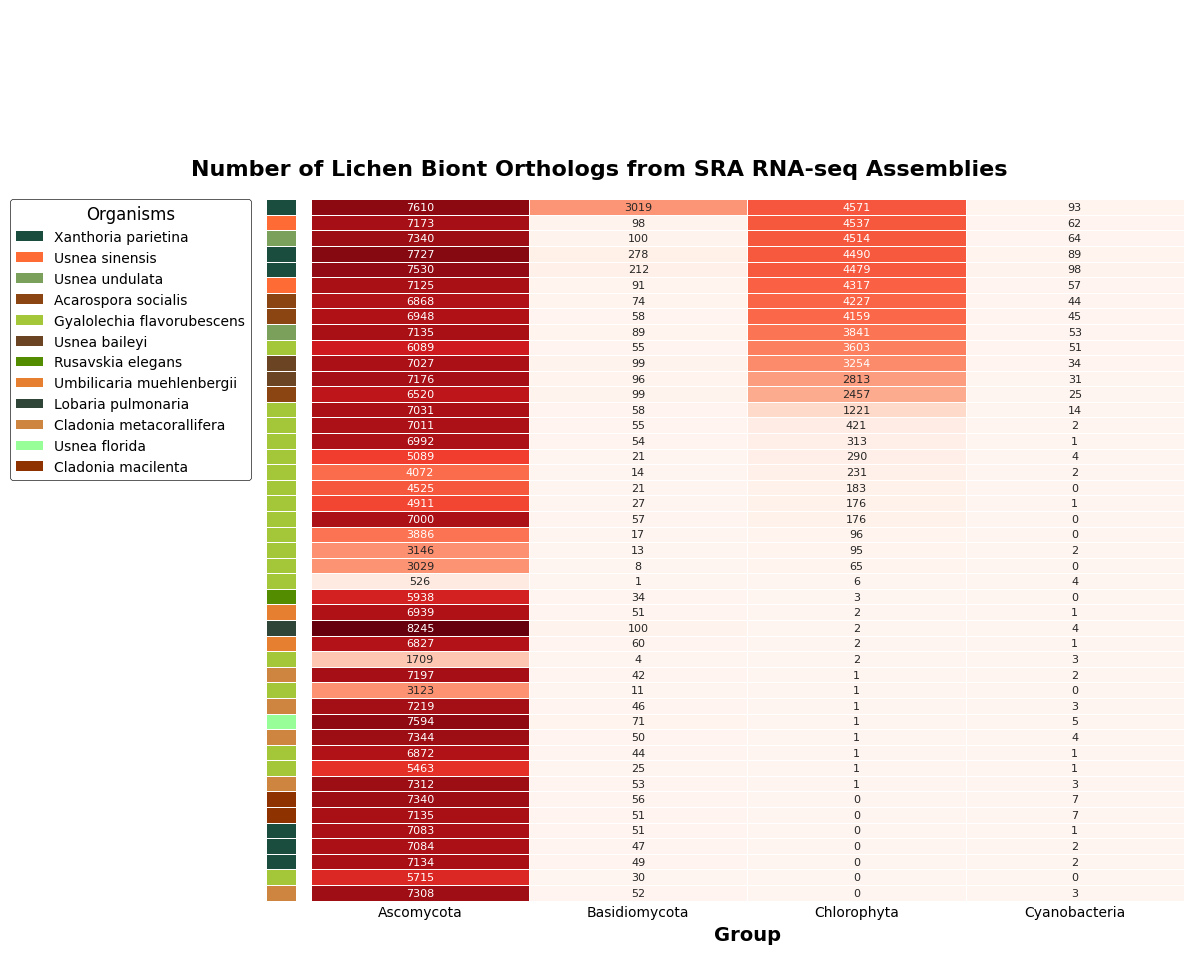

In [25]:
groups = {
    'Ascomycota': 'Ascomycota',
    'Basidiomycota': 'Basidiomycota',
    'Chlorophyta': 'Chlorophyta',
    'Cyanobacteria': 'Cyanobacteria',
}

phyla_count_df = transform_results(data, groups).sort_values(by='Chlorophyta', ascending=False)

lichen_spaced = [
    "#1B4D3E",  # Deep forest lichen
    "#FF6B35",  # Bright orange
    "#7BA05B",  # Medium lichen green
    "#8B4513",  # Saddle brown
    "#A4C639",  # Bright lichen
    "#6B4423",  # Dark bark brown
    "#548C00",  # Fresh moss
    "#E67F30",  # Light rust
    "#2F4538",  # Dark moss
    "#CD853F",  # Golden brown
    "#98FF98",  # Bright pale lichen
    "#8E3200"   # Deep rust
]

plot_lichen_heatmap(
    phyla_count_df, 
    figsize=(12, 10), 
    title='Number of Lichen Biont Orthologs from SRA RNA-seq Assemblies',
    palette=lichen_spaced
)

In [75]:
data.pipe(lambda df: df[df['eggnog_ogs'].str.contains('Bacteria').replace(np.nan, False)])['max_annot_lvl'].value_counts()

/tmp/ipykernel_425160/1902690804.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.pipe(lambda df: df[df['eggnog_ogs'].str.contains('Bacteria').replace(np.nan, False)])['max_annot_lvl'].value_counts()


max_annot_lvl
204457|Sphingomonadales          3765
201174|Actinobacteria            1766
28211|Alphaproteobacteria        1411
1117|Cyanobacteria               1266
2|Bacteria                        963
1236|Gammaproteobacteria          663
91061|Bacilli                     648
204458|Caulobacterales            592
976|Bacteroidetes                 586
186801|Clostridia                 518
28221|Deltaproteobacteria         512
28216|Betaproteobacteria          432
1224|Proteobacteria               322
204441|Rhodospirillales           151
135614|Xanthomonadales             94
1297|Deinococcus-Thermus           72
135619|Oceanospirillales           59
200795|Chloroflexi                 55
204432|Acidobacteriia              49
203682|Planctomycetes              48
203691|Spirochaetes                41
84995|Rubrobacteria                40
526524|Erysipelotrichia            38
84998|Coriobacteriia               35
29547|Epsilonproteobacteria        31
135623|Vibrionales                 3

,,Bacteria
sample_id,organism,
SRR10444679,Xanthoria parietina,371
SRR10444680,Xanthoria parietina,409
SRR10444681,Xanthoria parietina,386
SRR10444682,Xanthoria parietina,32
SRR10444683,Xanthoria parietina,33
SRR10444684,Xanthoria parietina,35
SRR14292007,Cladonia macilenta,42
SRR14292008,Cladonia macilenta,38
SRR18070778,Gyalolechia flavorubescens,29


In [55]:
data

,seqhash_id,sample_id,length,is_representative,description,preferred_name,cog_category,evalue,seed_ortholog,max_annot_lvl,eggnog_ogs,cluster_id,cluster_size,organism,study_title,bioproject,biosample
0,v1_DLS_7cebc687cc62badbe3ae73b19ad7f6fbb4d9c90...,SRR10444679,141,False,Belongs to the ubiquitin-conjugating enzyme fa...,MMS2,O,3.060000e-91,470704.XP_007758730.1,4751|Fungi,"KOG0896@1|root,KOG0896@2759|Eukaryota,3A1Q5@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
1,v1_DLS_828fed7e754ba0339e34e0272bc942780d38334...,SRR10444679,123,False,Eukaryotic translation initiation factor 1b,EIF1B,J,4.280000e-45,7918.ENSLOCP00000015935,33208|Metazoa,"COG0023@1|root,KOG1770@2759|Eukaryota,3A5KV@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
2,v1_DLS_8291f1cd6817b6cf25c9d9a146cf75b1263a327...,SRR10444679,407,False,alcohol dehydrogenase,-,Q,3.300000e-177,364733.XP_007802680.1,4751|Fungi,"COG1028@1|root,KOG1208@2759|Eukaryota,38IZP@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
3,v1_DLS_875252392e06b18b9718846fd3ed7d255b96c4f...,SRR10444679,140,False,Belongs to the eukaryotic ribosomal protein eS...,-,J,4.710000e-71,43228.XP_007732819.1,4751|Fungi,"COG2004@1|root,KOG3424@2759|Eukaryota,3A1MU@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
4,v1_DLS_93524c13f3f165a4f274427c629f67f5e53e5bc...,SRR10444679,342,False,quinone oxidoreductase,-,C,4.980000e-99,3827.XP_004485716.1,35493|Streptophyta,"COG0604@1|root,KOG1198@2759|Eukaryota,37K89@33...",None,NaN,Xanthoria parietina,Xanthoria parietina 46-1 Gene Expression Profi...,PRJNA584076,SAMN13173247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082168,v1_DLS_ad1c14acda031cd2578ce727cfaa13f158a8e3f...,SRR8859644,108,False,None,None,None,NaN,None,None,None,None,NaN,Usnea baileyi,Transcriptomic Analysis of Usnea sp.,PRJNA530379,SAMN11313033
1082169,v1_DLS_b7f9f780a14489506cac4132a2cf3d0eb0692a6...,SRR8859644,109,False,None,None,None,NaN,None,None,None,None,NaN,Usnea baileyi,Transcriptomic Analysis of Usnea sp.,PRJNA530379,SAMN11313033
1082170,v1_DLS_b97dff4979cfc8df4946716b90f46a79a8e8831...,SRR8859644,212,False,None,None,None,NaN,None,None,None,None,NaN,Usnea baileyi,Transcriptomic Analysis of Usnea sp.,PRJNA530379,SAMN11313033
1082171,v1_DLS_c72d45a1bf6378dbf6bbd63cc11de51e79b7184...,SRR8859644,150,False,None,None,None,NaN,None,None,None,None,NaN,Usnea baileyi,Transcriptomic Analysis of Usnea sp.,PRJNA530379,SAMN11313033


In [25]:
phyla_count_df.head()

,,Ascomycota,Basidiomycota,Chlorophyta,Cyanobacteria
sample_id,organism,,,,
SRR10444679,Xanthoria parietina,7727,278,4490,89
SRR10444680,Xanthoria parietina,7530,212,4479,98
SRR10444681,Xanthoria parietina,7610,3019,4571,93
SRR10444682,Xanthoria parietina,7084,47,0,2
SRR10444683,Xanthoria parietina,7083,51,0,1


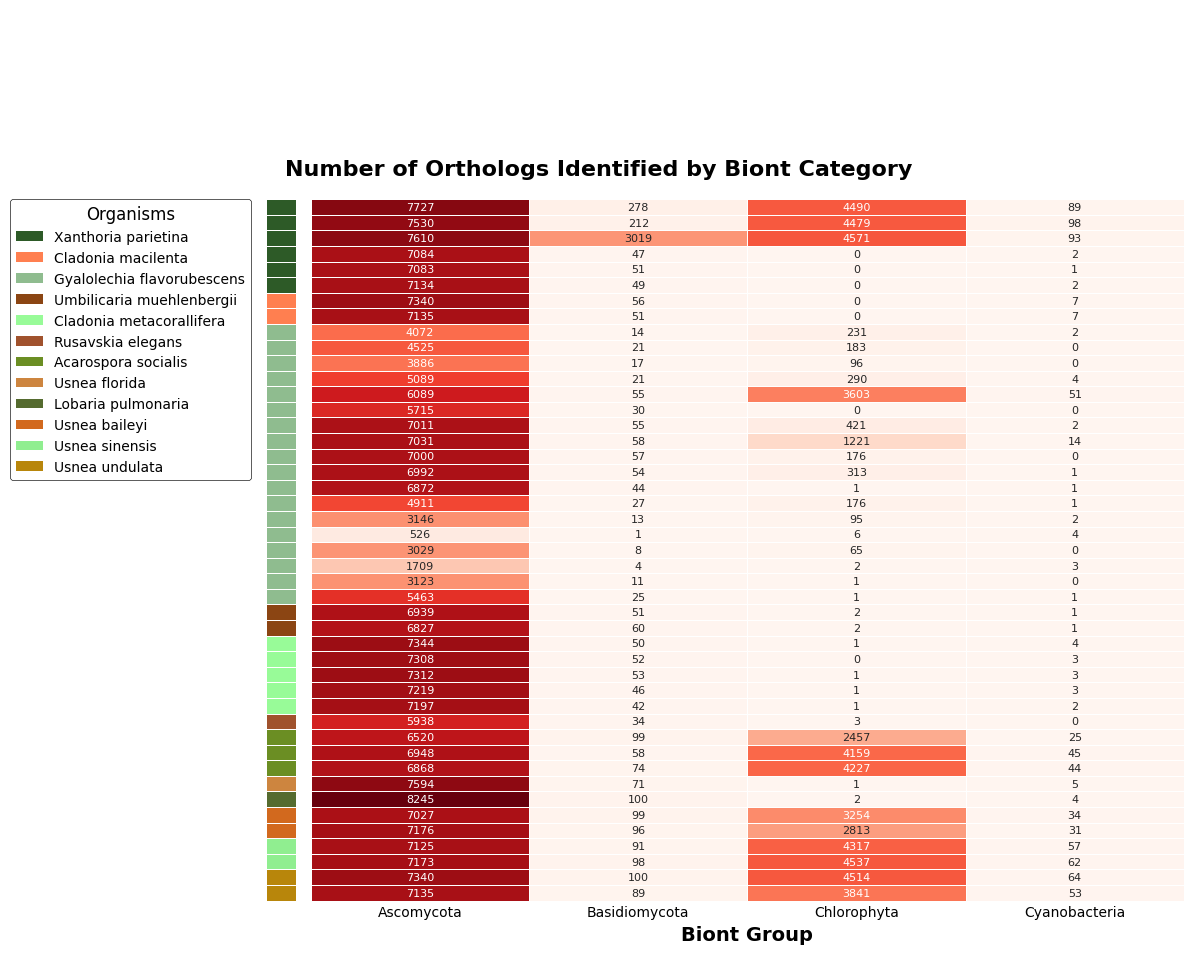

In [52]:
# Lichen-inspired palette with colors from real lichens
# Bright lichen palette (for more contrast)
lichen_natural = [
    "#AFC8AD",  # Pale lichen green
    "#E49B5D",  # Sunburst orange
    "#94A684",  # Forest lichen
    "#B99B6B",  # Crusty brown
    "#D4C5A9",  # Pale parchment
    "#4F6F52",  # Deep moss
    "#C8B88A",  # Weathered thallus
    "#AA7B6C",  # Faded fruiting body
    "#9DA9A0",  # Ashen gray
    "#DED0B6",  # Pale desert lichen
    "#7D8471",  # Sage lichen
    "#B4925A"   # Golden lichen
]
lichen_palette = [
    "#7EB394",  # Usnea green-gray
    "#FF9966",  # Xanthoria orange
    "#AEBD7F",  # Flavoparmelia sage
    "#904C2F",  # Cladonia rust brown
    "#E6D1AC",  # Reindeer lichen pale
    "#2F4538",  # Dark forest lichen
    "#BDB76B",  # Common greenshield
    "#D67F5B",  # British soldiers red
    "#8B8B6E",  # Old man's beard gray
    "#C1CDC1",  # Powdery gray
    "#6B8E23",  # Wolf lichen green
    "#CD853F"   # Tree lungwort brown
]

# Or more spaced out contrast:
lichen_spaced = [
    "#1B4D3E",  # Deep forest lichen
    "#FF6B35",  # Bright orange
    "#7BA05B",  # Medium lichen green
    "#8B4513",  # Saddle brown
    "#A4C639",  # Bright lichen
    "#6B4423",  # Dark bark brown
    "#548C00",  # Fresh moss
    "#E67F30",  # Light rust
    "#2F4538",  # Dark moss
    "#CD853F",  # Golden brown
    "#98FF98",  # Bright pale lichen
    "#8E3200"   # Deep rust
]

lichen_contrast = [
    "#2D5A27",  # Deep lichen green
    "#FF7F50",  # Vibrant coral (like Xanthoria)
    "#8FBC8F",  # Sage lichen green
    "#8B4513",  # Rich bark brown
    "#98FB98",  # Pale lichen green
    "#A0522D",  # Sienna brown
    "#6B8E23",  # Olive green
    "#CD853F",  # Peru brown
    "#556B2F",  # Dark olive
    "#D2691E",  # Chocolate
    "#90EE90",  # Light green
    "#B8860B"   # Dark golden
]
plot_lichen_heatmap(
    phyla_count_df, 
    figsize=(12, 10), 
    title='Number of Orthologs Identified by Biont Category',
    palette=lichen_contrast
)

In [ ]:
# lichen_results[lichen_results['eggnog_ogs'].str.contains('Cyanobacteria')]

# Update database

In [ ]:
from planter.database.builder import SequenceDBBuilder
# Define paths
DB_PATH = "/mnt/data2/planter_outputs/planter-test.duckdb"
OUTPUT_DIR = Path("/mnt/data2/planter_outputs")

with SequenceDBBuilder(DB_PATH, output_dir=OUTPUT_DIR) as builder:
    # Add new sample
    new_results = builder.update_database(['ERR4235136'])
